In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-07-07 17:04:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   212MB/s    in 0.8s    

2022-07-07 17:04:25 (212 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



## **Preparing the data**


In [ ]:
# Find out how many images are in a file
import os
import numpy as np
import pathlib


total_item = len(os.listdir('10_food_classes_10_percent/train'))
print(f"Number of items: {total_item}")

train_dir = pathlib.Path('10_food_classes_10_percent/train')  # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in train_dir.glob('*')])) # created a list of class_names from the subdirectories
print(f"Items name: {class_names}")

num_img_1class = len(os.listdir('10_food_classes_10_percent/train/chicken_curry'))
print(f"Total images in one class: {num_img_1class}")

Number of items: 10
Items name: ['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']
Total images in one class: 75


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## **Using simple CNN model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [ ]:
# Try a simplified model 
model_1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation='softmax')
])

# Compile the cloned model (same setup as used for model_10)
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_10_percent, 
                          epochs=5,
                          steps_per_epoch=len(train_data_10_percent),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 15s 575ms/step - loss: 2.4942 - accuracy: 0.1440 - val_loss: 2.2404 - val_accuracy: 0.1508
Epoch 2/5
24/24 [==============================] - 13s 574ms/step - loss: 1.9246 - accuracy: 0.3933 - val_loss: 2.2364 - val_accuracy: 0.1924
Epoch 3/5
24/24 [==============================] - 14s 586ms/step - loss: 1.4129 - accuracy: 0.5693 - val_loss: 2.2119 - val_accuracy: 0.2220
Epoch 4/5
24/24 [==============================] - 13s 567ms/step - loss: 0.9337 - accuracy: 0.7813 - val_loss: 2.3554 - val_accuracy: 0.2300
Epoch 5/5
24/24 [==============================] - 13s 569ms/step - loss: 0.5010 - accuracy: 0.9013 - val_loss: 2.4974 - val_accuracy: 0.2228


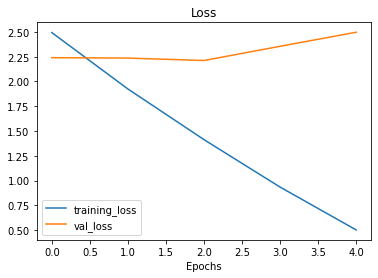

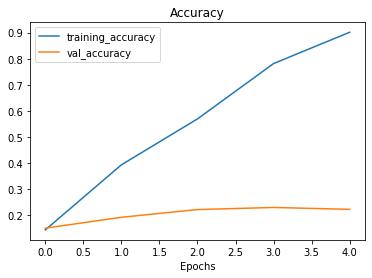

In [ ]:
# Check out our model's performance with augmented data
plot_loss_curves(history_1)

## **Using Tensorflow Hub** 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

### Some Functions

In [ ]:
def create_model(model_url, num_classes=10):

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape | (224, 224, 3)
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### ResNet50V2

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220707-165003
Epoch 1/5
24/24 [==============================] - 425s 18s/step - loss: 1.8210 - accuracy: 0.4027 - val_loss: 1.1122 - val_accuracy: 0.6396
Epoch 2/5
24/24 [==============================] - 416s 18s/step - loss: 0.8553 - accuracy: 0.7493 - val_loss: 0.8158 - val_accuracy: 0.7332
Epoch 3/5
24/24 [==============================] - 413s 18s/step - loss: 0.5943 - accuracy: 0.8333 - val_loss: 0.7308 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 412s 18s/step - loss: 0.4668 - accuracy: 0.8747 - val_loss: 0.6888 - val_accuracy: 0.7728
Epoch 5/5
24/24 [==============================] - 412s 18s/step - loss: 0.3722 - accuracy: 0.9160 - val_loss: 0.6799 - val_accuracy: 0.7744


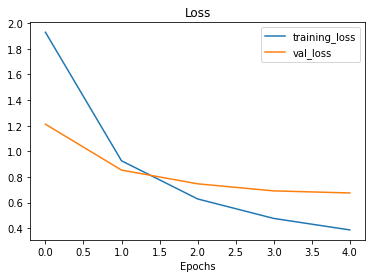

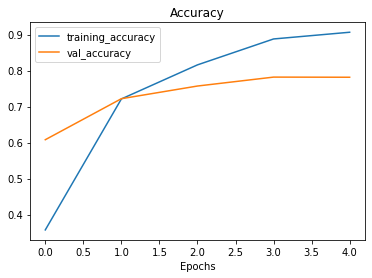

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### EfficientNetB0 

In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220707-170852
Epoch 1/5
24/24 [==============================] - 30s 706ms/step - loss: 1.8292 - accuracy: 0.4493 - val_loss: 1.2979 - val_accuracy: 0.7168
Epoch 2/5
24/24 [==============================] - 15s 633ms/step - loss: 1.0473 - accuracy: 0.7813 - val_loss: 0.8682 - val_accuracy: 0.8108
Epoch 3/5
24/24 [==============================] - 15s 632ms/step - loss: 0.7523 - accuracy: 0.8320 - val_loss: 0.6996 - val_accuracy: 0.8436
Epoch 4/5
24/24 [==============================] - 15s 636ms/step - loss: 0.6003 - accuracy: 0.8813 - val_loss: 0.6119 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 15s 660ms/step - loss: 0.5054 - accuracy: 0.8973 - val_loss: 0.5599 - val_accuracy: 0.8616


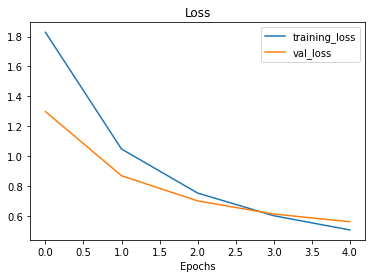

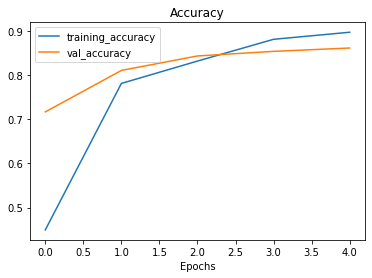

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
